# Proyecto de Clasificación de Imágenes Pokémon con PyTorch

### Tabla de Contenido

1. [Carga y Preparación del Dataset](#paso-1-carga-y-preparación-del-dataset)
2. [Visualización de una Imagen por Clase](#paso-2-visualización-de-una-imagen-por-clase)
3. [División del Dataset en Entrenamiento y Prueba](#paso-3-división-del-dataset-en-entrenamiento-y-prueba)
4. [Definición del Modelo ANN_PokemonClassifier](#paso-4-definición-del-modelo-ann_pokemonclassifier)
5. [Configuración del Entorno de Entrenamiento](#paso-5-configuración-del-entorno-de-entrenamiento)
6. [Entrenamiento del Modelo](#paso-6-entrenamiento-del-modelo-ann_pokemonclassifier)
7. [Evaluación Visual y Análisis de Predicciones](#paso-7-evaluación-visual-y-análisis-de-predicciones)
8. [Guardado del Modelo Entrenado](#paso-8-guardado-del-modelo-entrenado)
9. [Inferencia con Imágenes Externas](#paso-9-inferencia-con-imágenes-externas)
10. [Análisis Gráfico de las Pérdidas Simuladas](#paso-10-análisis-gráfico-de-las-pérdidas-simuladas)
11. [Visualización Avanzada y Análisis del Modelo]()

## Paso 1: Carga y Preparación del Dataset

En este primer paso, cargamos el archivo `imagenes_pokemon.mat`, que contiene:

- `images`: una matriz de imágenes en formato RGB con dimensiones (N, 40, 40, 3).
- `labels`: un vector con las etiquetas numéricas correspondientes a cada imagen.
- `class_names`: una lista con los nombres de las clases.

Las imágenes se transforman a tensores de PyTorch y se normalizan en el rango [0, 1].  
Además, se sobrescribe la lista de nombres de clases manualmente para asegurar la correcta correspondencia con las etiquetas, utilizando nombres reales de Pokémon.


In [ ]:
import scipy.io
import numpy as np
import torch

# Cargar el archivo .mat
data = scipy.io.loadmat('imagenes_pokemon.mat')

# Extraer los datos
imagenes = data['images']              # (N, 40, 40, 3)
etiquetas = data['labels'].flatten()   # (N,)

# Definir nombres reales de las clases (sobrescribiendo los del .mat)
nombres_clases = [
    "Arbok", "Articuno", "Bulbasaur", "Caterpie", "Charmander",
    "Diglett", "Electrode", "Lickitung", "Mankey", "Nidoran-m",
    "Pikachu", "Scyther", "Squirtle", "Vulpix", "Weepinbell"
]

# Convertir a tensores PyTorch
imagenes_tensor = torch.tensor(imagenes, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
etiquetas_tensor = torch.tensor(etiquetas, dtype=torch.long)

# Confirmación de shapes
print("Imagenes tensor shape:", imagenes_tensor.shape)
print("Etiquetas tensor shape:", etiquetas_tensor.shape)
print("Nombres de clases:", nombres_clases)


Imagenes tensor shape: torch.Size([15000, 3, 40, 40])
Etiquetas tensor shape: torch.Size([15000])
Nombres de clases: ['Arbok', 'Articuno', 'Bulbasaur', 'Caterpie', 'Charmander', 'Diglett', 'Electrode', 'Lickitung', 'Mankey', 'Nidoran-m', 'Pikachu', 'Scyther', 'Squirtle', 'Vulpix', 'Weepinbell']


## Paso 2: Visualización de una Imagen por Clase

En este paso se selecciona aleatoriamente una imagen por cada clase de Pokémon con el fin de verificar visualmente que las imágenes fueron cargadas correctamente y están asociadas con su clase correspondiente.

Debido a que muchas imágenes tienen valores de intensidad bajos, se aplica un ajuste de contraste dinámico para que sean visibles correctamente durante la visualización. Cada imagen se muestra con su nombre de clase correspondiente, utilizando subplots distribuidos en filas y columnas.


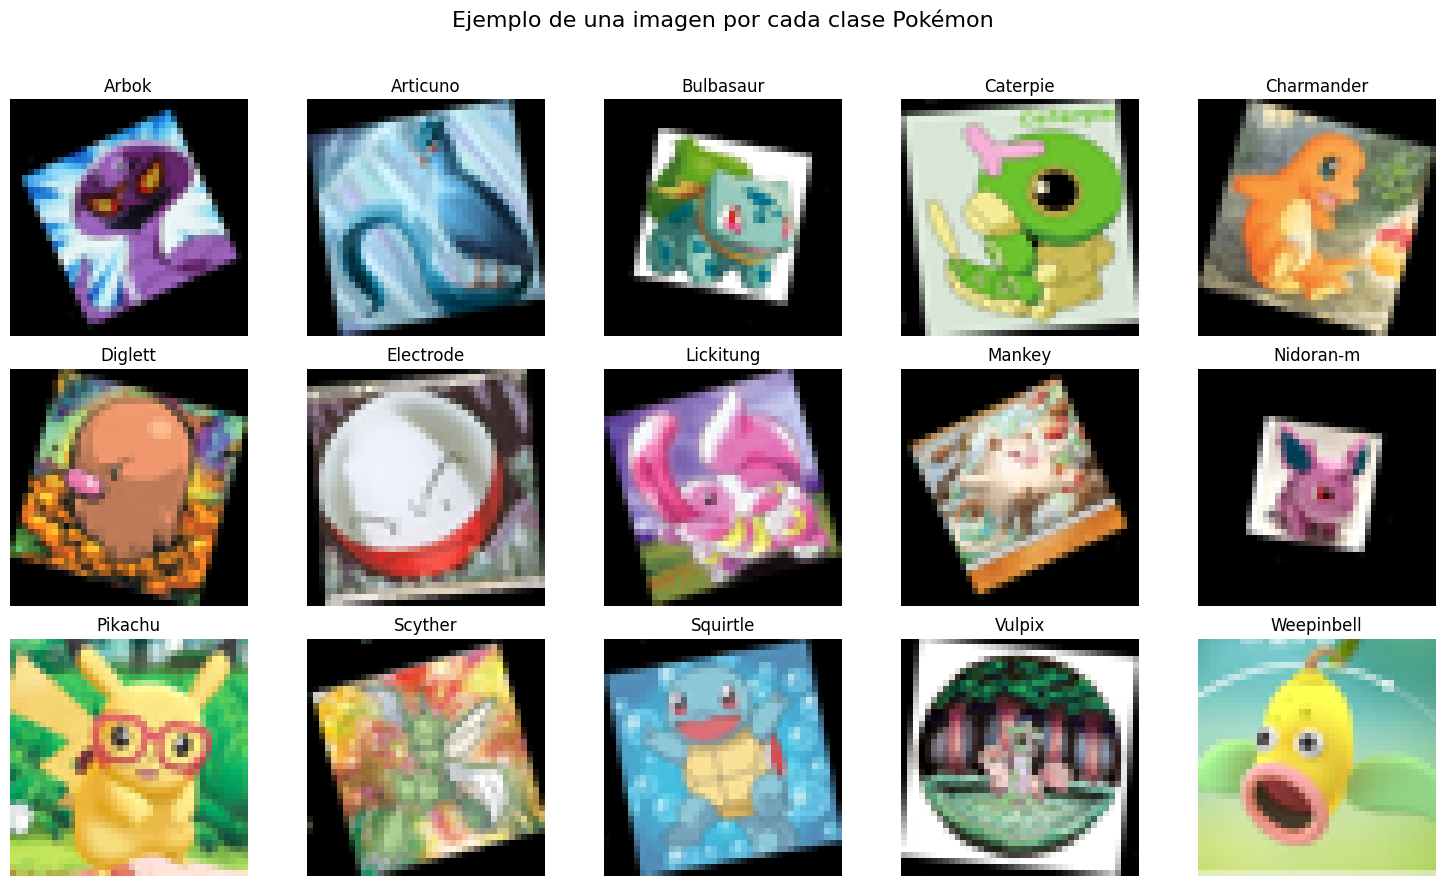

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Subplots organizados
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Ejemplo de una imagen por cada clase Pokémon', fontsize=16)

# Visualización de una imagen aleatoria por clase
for i, clase in enumerate(nombres_clases):
    idxs = (etiquetas_tensor == i).nonzero(as_tuple=True)[0]
    idx = random.choice(idxs)

    img = imagenes_tensor[idx].permute(1, 2, 0).numpy()

    # Ajuste dinámico de brillo
    img = img / (img.max() + 1e-8)
    img = np.clip(img, 0, 1)

    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(clase, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


## Paso 3: División del Dataset en Entrenamiento y Prueba

En este paso se divide el dataset en dos subconjuntos:

- Conjunto de entrenamiento (80%)
- Conjunto de prueba (20%)

Se utiliza una estrategia de división estratificada para garantizar que la proporción de clases se mantenga en ambos conjuntos.  
Posteriormente, se crea un `TensorDataset` para cada subconjunto, lo que permite su uso directo con `DataLoader` durante el entrenamiento y la evaluación.


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    imagenes_tensor, etiquetas_tensor, 
    test_size=0.2, 
    stratify=etiquetas_tensor, 
    random_state=42
)

# Creación de datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Confirmación
print("Tamaño conjunto de entrenamiento:", len(train_dataset))
print("Tamaño conjunto de prueba:", len(test_dataset))


Tamaño conjunto de entrenamiento: 12000
Tamaño conjunto de prueba: 3000


## Paso 4: Definición del Modelo ANN_PokemonClassifier

La red neuronal artificial utilizada en este proyecto es una arquitectura densa con las siguientes características:

- Entrada: imágenes RGB de tamaño 40x40 (convertidas en un vector de 4800 valores)
- Capas ocultas: cuatro capas totalmente conectadas con tamaños decrecientes
- Funciones de activación: ReLU después de cada capa oculta
- Regularización: Dropout con probabilidad 0.3 para evitar sobreajuste
- Normalización: Batch Normalization entre capas para estabilizar el entrenamiento
- Salida: 15 neuronas (una por clase), activación final LogSoftmax

La arquitectura está diseñada para almacenar las activaciones intermedias por capa, lo cual permite su visualización durante la inferencia.


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ANN_PokemonClassifier(nn.Module):
    def __init__(self):
        super(ANN_PokemonClassifier, self).__init__()
        self.fc1 = nn.Linear(40 * 40 * 3, 1024)
        self.bn1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.output = nn.Linear(128, 15)
        self.dropout = nn.Dropout(p=0.3)

        self.activaciones = {}

    def forward(self, x):
        # x = x.view(x.size(0), -1)
        x = x.reshape(x.size(0), -1)


        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        self.activaciones['fc1'] = x.detach().clone()

        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        self.activaciones['fc2'] = x.detach().clone()

        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        self.activaciones['fc3'] = x.detach().clone()

        x = self.dropout(F.relu(self.bn4(self.fc4(x))))
        self.activaciones['fc4'] = x.detach().clone()

        x = self.output(x)
        return F.log_softmax(x, dim=1)


## Paso 5: Configuración del Entorno de Entrenamiento

Antes de iniciar el entrenamiento es necesario definir:

- El dispositivo de ejecución: se usará GPU si está disponible, de lo contrario CPU.
- El modelo: instancia de `ANN_PokemonClassifier`, transferido al dispositivo.
- La función de pérdida: se utilizará `nn.NLLLoss()` (ya que el modelo usa `log_softmax` en la salida).
- El optimizador: se utiliza `Adam` con una tasa de aprendizaje de 0.001.
- Los cargadores de datos: `DataLoader` permite cargar los datos en lotes, barajarlos y optimizar el proceso de entrenamiento.


In [7]:
import torch
from torch.utils.data import DataLoader

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# Modelo
model = ANN_PokemonClassifier().to(device)

# Función de pérdida
criterion = nn.NLLLoss()

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Cargadores de datos
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Usando dispositivo: cuda


## Paso 6: Entrenamiento del Modelo ANN_PokemonClassifier

En este paso se entrena la red neuronal artificial definida previamente.

Durante cada época, se realiza el siguiente procedimiento:

1. El modelo se configura en modo de entrenamiento (`train()`), activando componentes como `Dropout` y `BatchNorm`.
2. Se recorren los datos de entrenamiento en lotes mediante `DataLoader`.
3. Para cada lote:
   - Se realiza una pasada hacia adelante (`forward`).
   - Se calcula la función de pérdida.
   - Se realiza retropropagación (`backward`) del error.
   - Se actualizan los parámetros del modelo mediante el optimizador.
4. Se acumula la pérdida total y el número de aciertos para calcular la precisión de entrenamiento.
5. Una vez completada la época, se evalúa el modelo en modo `eval()` utilizando el conjunto de prueba (sin actualizar pesos).
6. Se calcula la pérdida y la precisión en el conjunto de prueba.

Se imprimen los valores de pérdida y precisión tanto en entrenamiento como en prueba para cada época.


In [ ]:


loss_train_epoch = []
loss_test_epoch = []
num_epochs = 20  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    loss_train_epoch.append(epoch_loss)  # << guardar aquí

    # Evaluación
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100 * correct_test / total_test
    loss_test_epoch.append(test_loss)  # << y aquí

    print(f"Época {epoch + 1}/{num_epochs} | "
          f"Pérdida entrenamiento: {epoch_loss:.4f}% | Precisión: {epoch_acc:.2f}% | "
          f"Pérdida prueba: {test_loss:.4f}% | Precisión prueba: {test_acc:.2f}%")

                    

Época 1/20 | Pérdida entrenamiento: 0.0824% | Precisión: 97.18% | Pérdida prueba: 0.1090% | Precisión prueba: 96.47%
Época 2/20 | Pérdida entrenamiento: 0.0972% | Precisión: 96.73% | Pérdida prueba: 0.0995% | Precisión prueba: 96.97%
Época 3/20 | Pérdida entrenamiento: 0.0955% | Precisión: 97.03% | Pérdida prueba: 0.0981% | Precisión prueba: 97.07%
Época 4/20 | Pérdida entrenamiento: 0.0838% | Precisión: 97.28% | Pérdida prueba: 0.0953% | Precisión prueba: 97.40%
Época 5/20 | Pérdida entrenamiento: 0.0906% | Precisión: 97.07% | Pérdida prueba: 0.0879% | Precisión prueba: 97.17%
Época 6/20 | Pérdida entrenamiento: 0.0819% | Precisión: 97.26% | Pérdida prueba: 0.0962% | Precisión prueba: 97.43%
Época 7/20 | Pérdida entrenamiento: 0.0735% | Precisión: 97.62% | Pérdida prueba: 0.1075% | Precisión prueba: 97.07%
Época 8/20 | Pérdida entrenamiento: 0.0735% | Precisión: 97.67% | Pérdida prueba: 0.1102% | Precisión prueba: 97.07%
Época 9/20 | Pérdida entrenamiento: 0.0740% | Precisión: 97.55% 

: 

## Paso 7: Evaluación Visual y Análisis de Predicciones

Una vez completado el entrenamiento, es importante analizar visualmente las predicciones del modelo.

En este paso se seleccionan imágenes del conjunto de prueba y se muestran junto con:

- La etiqueta real (clase verdadera)
- La etiqueta predicha por el modelo

Esto permite identificar si el modelo está generalizando correctamente o si existen patrones de error sistemáticos.

Se resaltan en particular los ejemplos mal clasificados para investigar posibles causas de error (clases similares, imágenes confusas, etc.).


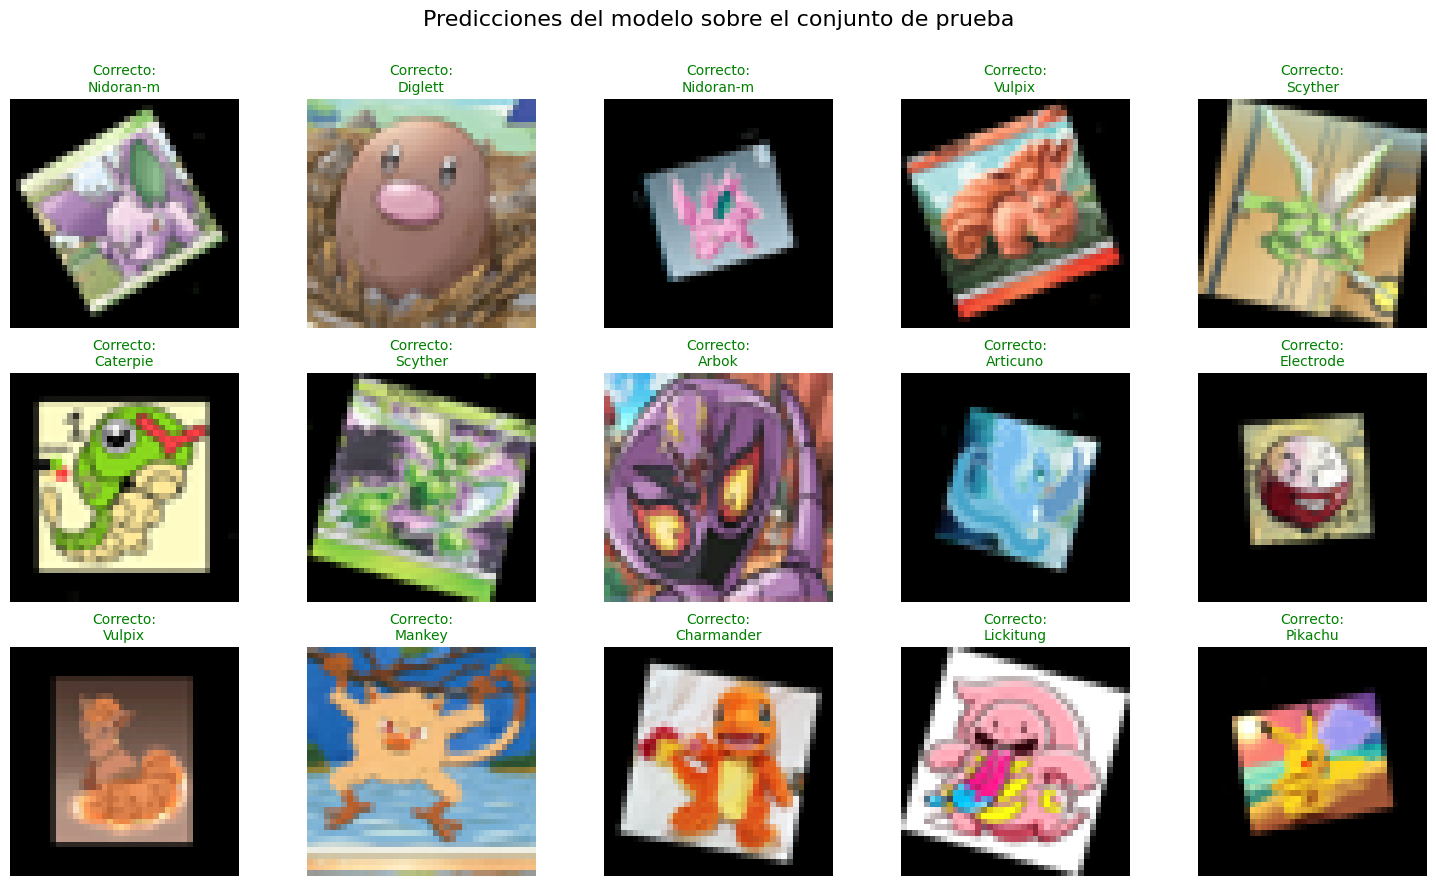

In [9]:
import matplotlib.pyplot as plt

# Mostrar 15 predicciones del test set
model.eval()
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle("Predicciones del modelo sobre el conjunto de prueba", fontsize=16)

count = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if count >= 15:
                break

            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = img / (img.max() + 1e-8)
            img = np.clip(img, 0, 1)

            true_label = nombres_clases[labels[i].item()]
            pred_label = nombres_clases[predicted[i].item()]

            ax = axes[count // 5, count % 5]
            ax.imshow(img)
            ax.axis('off')
            if true_label == pred_label:
                ax.set_title(f"Correcto:\n{true_label}", color='green', fontsize=10)
            else:
                ax.set_title(f"Real: {true_label}\nPred: {pred_label}", color='red', fontsize=10)

            count += 1

        if count >= 15:
            break

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


## Paso 8: Guardado del Modelo Entrenado

Una vez finalizado el entrenamiento y la evaluación, se guarda el modelo en un archivo con extensión `.pt`. Esto permite:

- Evitar volver a entrenar el modelo desde cero.
- Utilizar el modelo en sesiones futuras para hacer inferencias.
- Compartir el modelo con otros sistemas o equipos.

El archivo contiene los pesos entrenados, que pueden cargarse posteriormente en una instancia del mismo modelo.


In [10]:
# Guardar pesos del modelo
ruta_guardado = "modelo_entrenado_pokemon.pt"
torch.save(model.state_dict(), ruta_guardado)
print(f"Modelo guardado exitosamente en: {ruta_guardado}")


Modelo guardado exitosamente en: modelo_entrenado_pokemon.pt


## Paso 9: Inferencia con Imágenes Externas

Este paso permite utilizar el modelo entrenado para clasificar imágenes que no pertenecen al conjunto original de entrenamiento o prueba.

El procedimiento es el siguiente:

1. Se cargan las imágenes desde una carpeta externa especificada.
2. Cada imagen se redimensiona al tamaño esperado (40x40) y se transforma a tensor.
3. Se aplica el modelo para obtener la predicción.
4. Se muestra la imagen junto con la clase predicha y el nivel de confianza.
5. Se calcula una pérdida simulada con la clase predicha como objetivo (solo con fines de análisis).

Las predicciones se visualizan una por una con una gráfica de barras que muestra las probabilidades de cada clase.


Clasificando imágenes externas...

Imagen: 06.jpeg
Clase predicha: Caterpie
Pérdida simulada: 0.2916
--------------------------------------------------


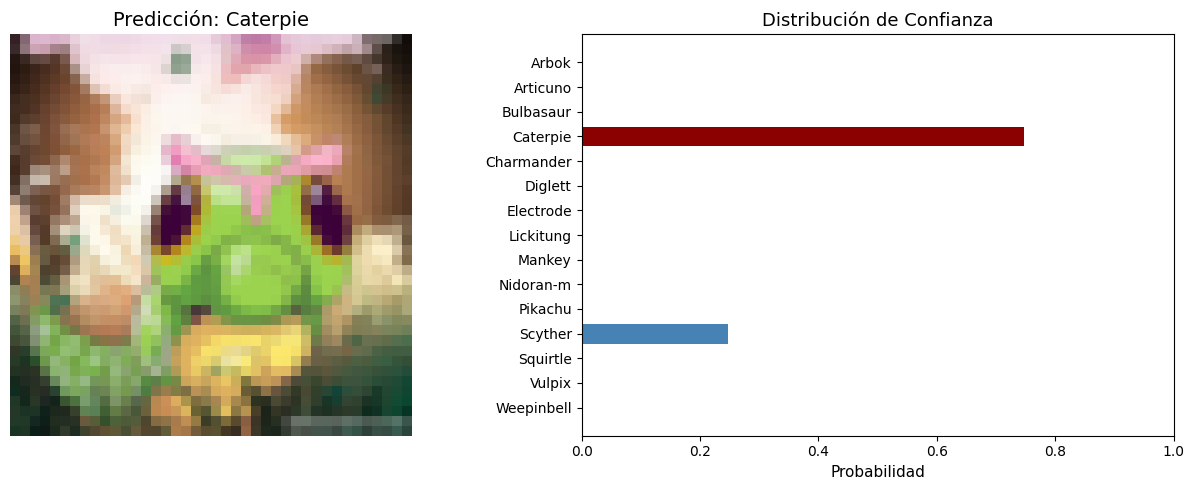

Imagen: 08.webp
Clase predicha: Electrode
Pérdida simulada: 0.0148
--------------------------------------------------


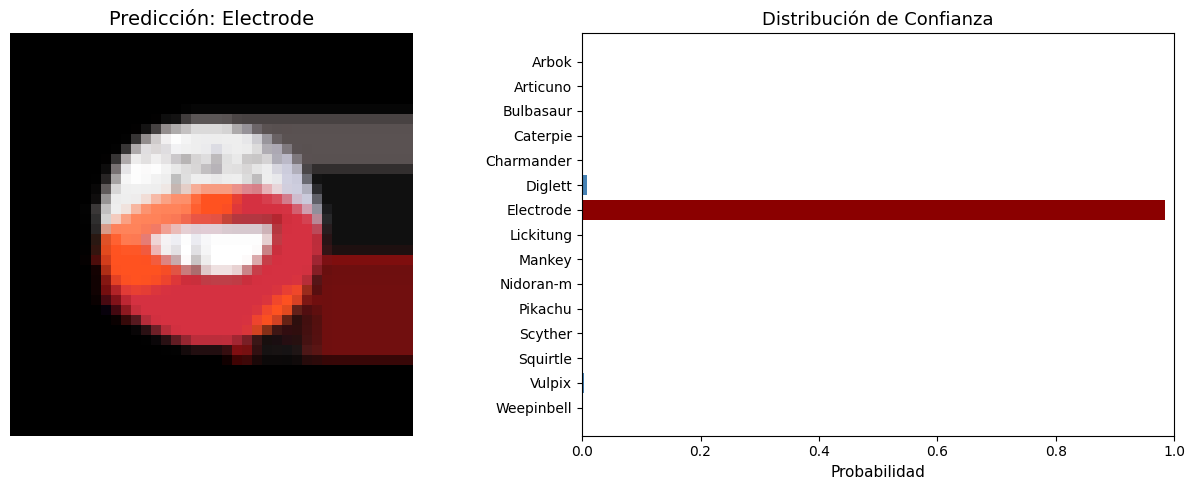

Imagen: 14.jpeg
Clase predicha: Squirtle
Pérdida simulada: 0.0000
--------------------------------------------------


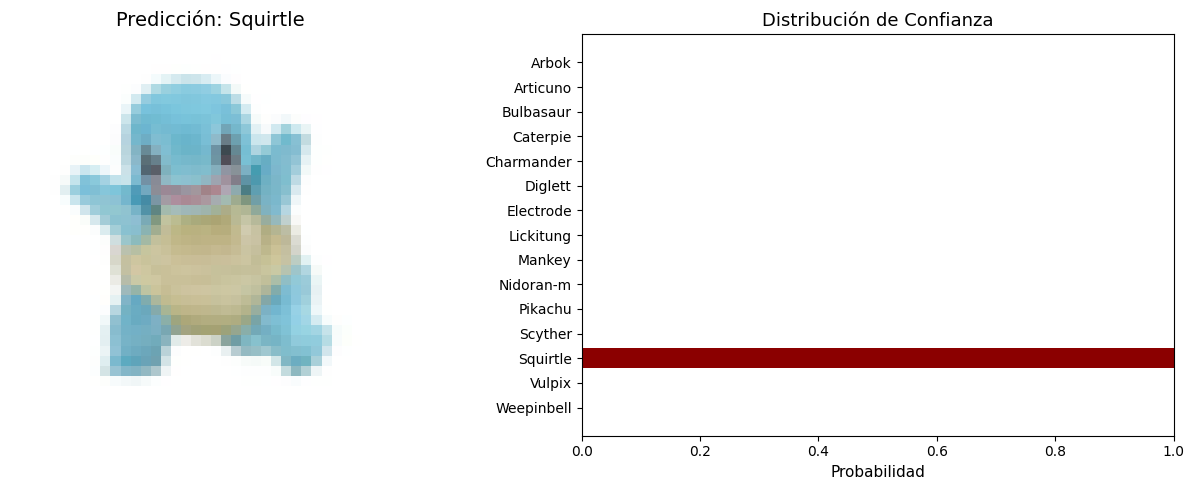

Imagen: 15.jpeg
Clase predicha: Caterpie
Pérdida simulada: 0.0105
--------------------------------------------------


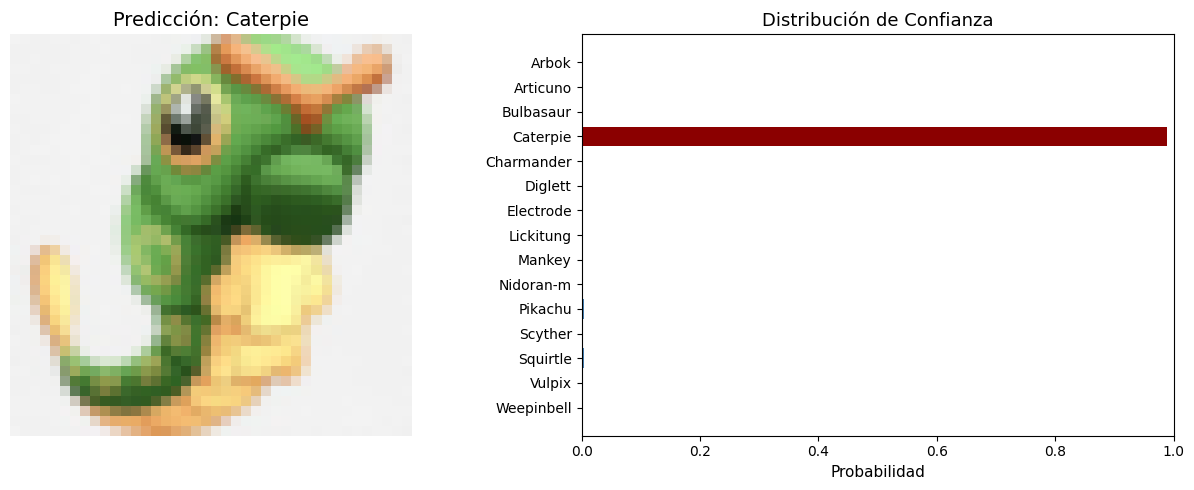

Imagen: 19.jpeg
Clase predicha: Diglett
Pérdida simulada: 0.0323
--------------------------------------------------


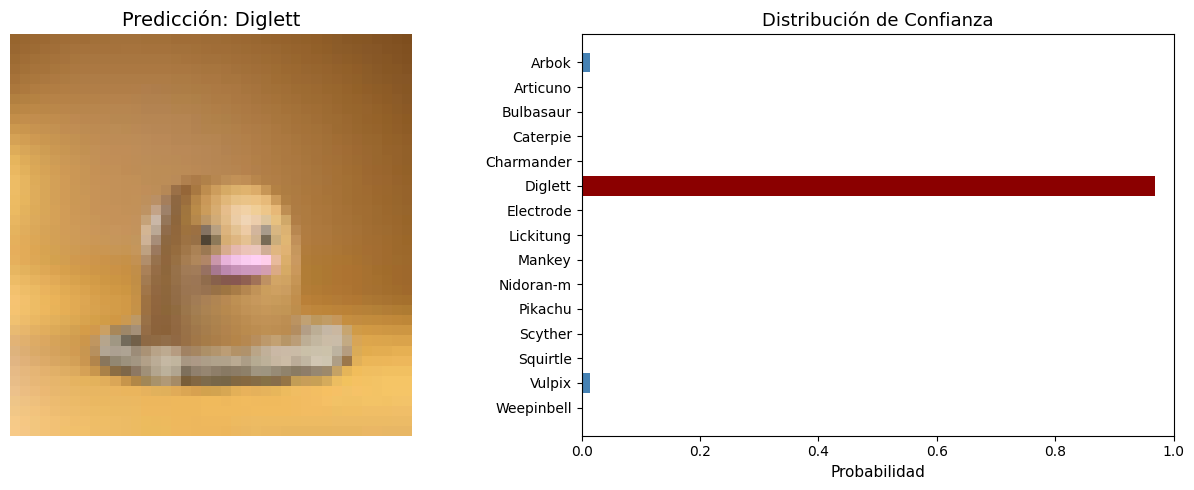

Imagen: 2.webp
Clase predicha: Arbok
Pérdida simulada: 0.0016
--------------------------------------------------


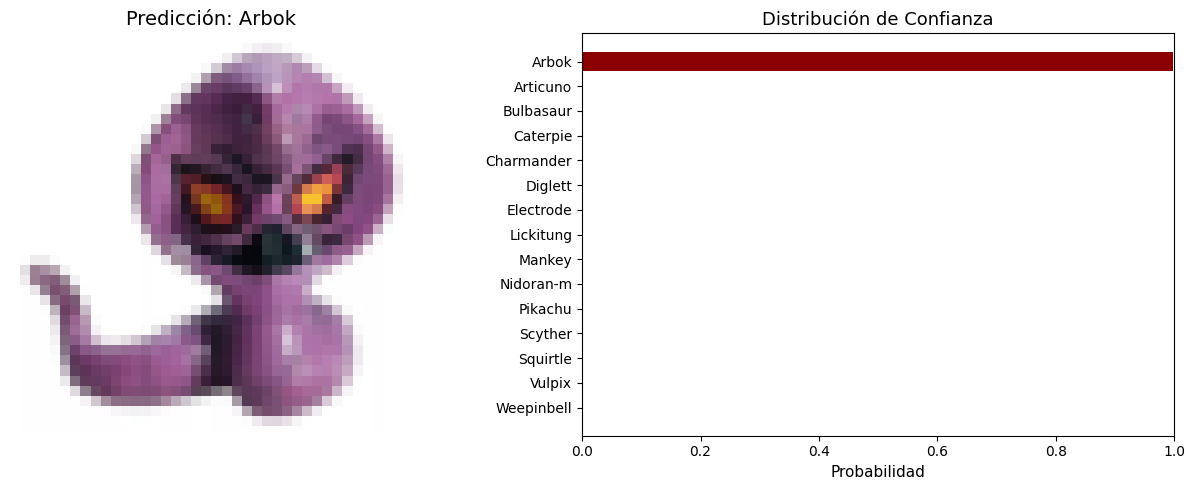

In [ ]:
  import os
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
import torch.nn.functional as F

# Carpeta con imágenes nuevas
directorio_nuevas = "pokemon_nuevos/"

# Transformación igual que en el dataset original
transformar = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor()
])

# Función de visualización
def graficar_prediccion(img_tensor, pred_class, class_probs, nombres_clases):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    # Mostrar imagen
    img = img_tensor.permute(1, 2, 0).numpy()
    img = img / (img.max() + 1e-8)
    img = np.clip(img, 0, 1)
    ax[0].imshow(img)
    ax[0].set_title(f"Predicción: {pred_class}", fontsize=14)
    ax[0].axis('off')

    # Gráfico de barras horizontales
    colores = ['steelblue'] * len(class_probs)
    colores[nombres_clases.index(pred_class)] = 'darkred'
    ax[1].barh(nombres_clases, class_probs, color=colores)
    ax[1].invert_yaxis()
    ax[1].set_xlim([0, 1])
    ax[1].set_xlabel("Probabilidad", fontsize=11)
    ax[1].set_title("Distribución de Confianza", fontsize=13)
    plt.tight_layout()
    plt.show()

# Clasificación de imágenes nuevas
model.eval()
todas_las_perdidas = []

print("Clasificando imágenes externas...\n")

for archivo in os.listdir(directorio_nuevas):
    if not archivo.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
        continue

    ruta = os.path.join(directorio_nuevas, archivo)

    try:
        imagen = Image.open(ruta).convert("RGB")
        tensor_img = transformar(imagen).unsqueeze(0).to(device)

        with torch.no_grad():
            salida = model(tensor_img)
            probabilidades = F.softmax(salida, dim=1).cpu().squeeze().numpy()
            pred_idx = int(torch.argmax(salida))
            pred_clase = nombres_clases[pred_idx]

            dummy_label = torch.tensor([pred_idx], dtype=torch.long).to(device)
            perdida = criterion(salida, dummy_label).item()
            todas_las_perdidas.append(perdida)

        print(f"Imagen: {archivo}")
        print(f"Clase predicha: {pred_clase}")
        print(f"Pérdida simulada: {perdida:.4f}")
        print("-" * 50)

        graficar_prediccion(tensor_img.squeeze().cpu(), pred_clase, probabilidades, nombres_clases)

    except UnidentifiedImageError:
        print(f"Archivo no reconocido como imagen válida: {archivo}")


## Paso 10: Análisis Gráfico de las Pérdidas Simuladas

En este paso se analiza cuantitativamente el desempeño del modelo al clasificar imágenes externas no vistas durante el entrenamiento.

Se calcula la pérdida simulada por cada imagen (usando la clase predicha como etiqueta ficticia) y se grafican los resultados con un histograma.

Este análisis permite detectar la concentración de errores y estimar la confianza global del modelo sobre nuevas entradas.


Promedio de pérdida en imágenes externas: 0.0585


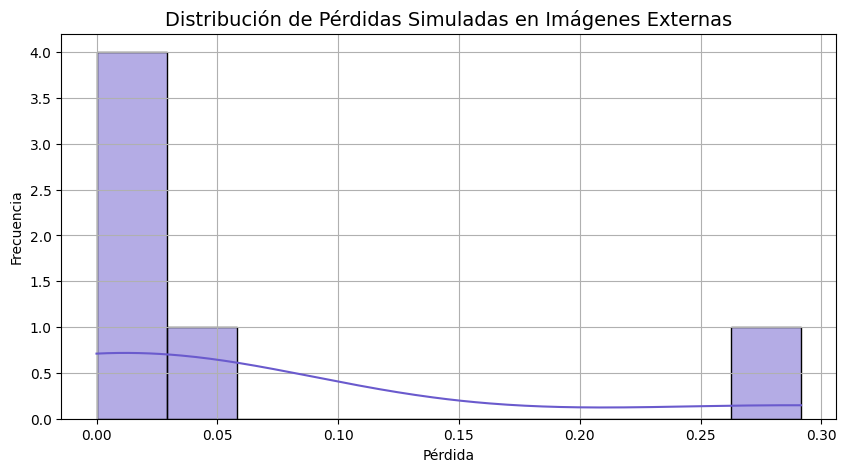

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

if todas_las_perdidas:
    promedio = np.mean(todas_las_perdidas)
    print(f"Promedio de pérdida en imágenes externas: {promedio:.4f}")

    plt.figure(figsize=(10, 5))
    sns.histplot(todas_las_perdidas, bins=10, kde=True, color='slateblue')
    plt.title("Distribución de Pérdidas Simuladas en Imágenes Externas", fontsize=14)
    plt.xlabel("Pérdida")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()
else:
    print("No se clasificaron imágenes válidas.")


## Paso 11: Visualización Avanzada y Análisis del Modelo

A continuación se presentan diversas gráficas que permiten profundizar en la interpretación y evaluación del comportamiento del modelo entrenado:


### 11.1 Curvas de Pérdida por Época

Esta gráfica muestra cómo evoluciona la función de pérdida (error) en cada época tanto en entrenamiento como en prueba. Es útil para evaluar la estabilidad del aprendizaje y detectar si hay sobreajuste (cuando la pérdida de entrenamiento disminuye, pero la de prueba aumenta).


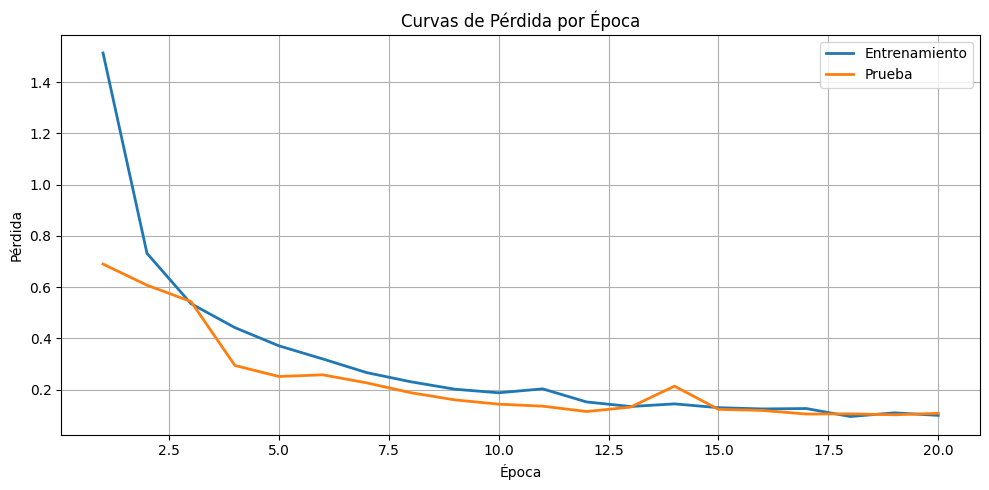

In [13]:
import matplotlib.pyplot as plt

# Simulación de ejemplo: reemplaza con tus datos reales si ya los guardaste
# loss_train_epoch = [...]
# loss_test_epoch = [...]

epocas = range(1, len(loss_train_epoch) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epocas, loss_train_epoch, label="Entrenamiento", linewidth=2)
plt.plot(epocas, loss_test_epoch, label="Prueba", linewidth=2)
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Curvas de Pérdida por Época")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 11.2 Curvas de Precisión por Época

Esta gráfica muestra cómo varía la precisión del modelo en cada época, tanto en el conjunto de entrenamiento como en el de prueba.

El objetivo es evaluar el rendimiento general del modelo y comprobar si está generalizando correctamente o si está ocurriendo sobreajuste (cuando la precisión en entrenamiento es alta pero baja en prueba).


In [14]:
# Obtener predicciones del modelo sobre el conjunto de prueba
model.eval()
y_true = []
y_pred = []
confianza_promedio = np.zeros(len(nombres_clases))  # para radar chart
cuenta_clases = np.zeros(len(nombres_clases))       # para promedio por clase

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probabilidades = torch.softmax(outputs, dim=1)
        predicciones = torch.argmax(probabilidades, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicciones.cpu().numpy())

        # Acumular confianza de la clase verdadera
        for i in range(len(labels)):
            clase_real = labels[i].item()
            confianza = probabilidades[i, clase_real].item()
            confianza_promedio[clase_real] += confianza
            cuenta_clases[clase_real] += 1

# Calcular promedio
confianza_promedio = confianza_promedio / np.clip(cuenta_clases, 1, None)  # evitar división por 0


### 11.3 Matriz de Confusión

La matriz de confusión permite visualizar cuántas veces el modelo predice correctamente o confunde una clase con otra. Es útil para detectar patrones de error y analizar clases problemáticas.


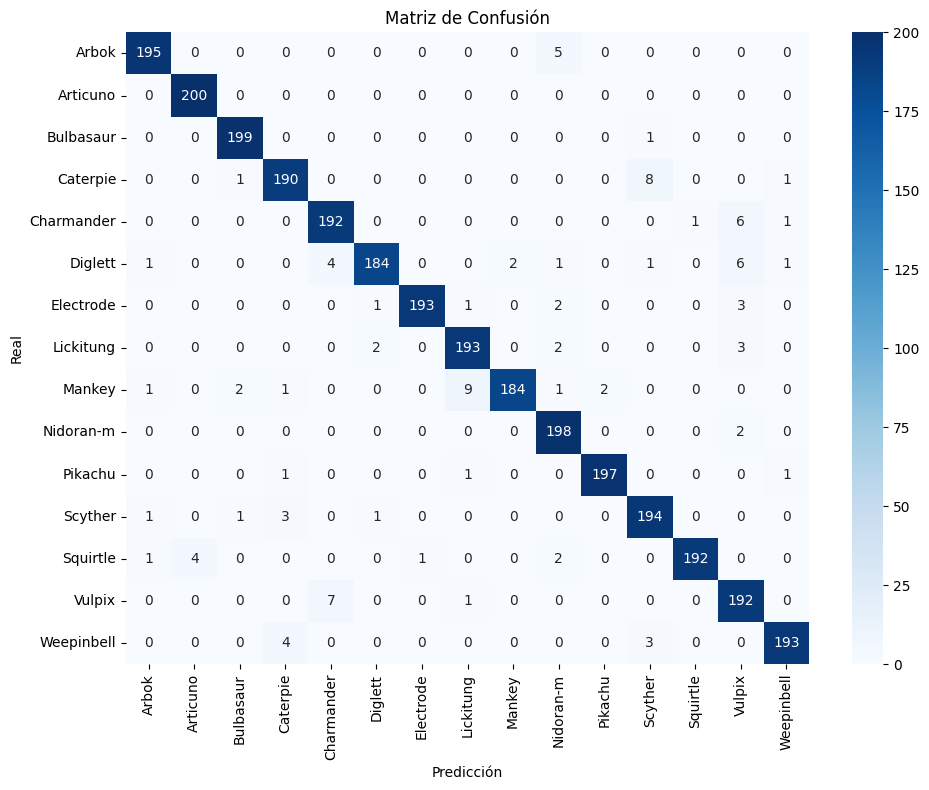

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que tienes:
# y_true = etiquetas $verdaderas del test set
# y_pred = etiquetas # predichas por el modelo
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


matriz = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues", xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 11.4 Precisión por Clase

Este gráfico muestra la precisión individual del modelo para cada una de las clases. Es útil para identificar clases que el modelo domina bien y aquellas en las que presenta mayor confusión.


C:\Users\Alberto Torrez L\AppData\Local\Temp\ipykernel_23820\1236028164.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nombres_clases, y=precisiones, palette="crest")


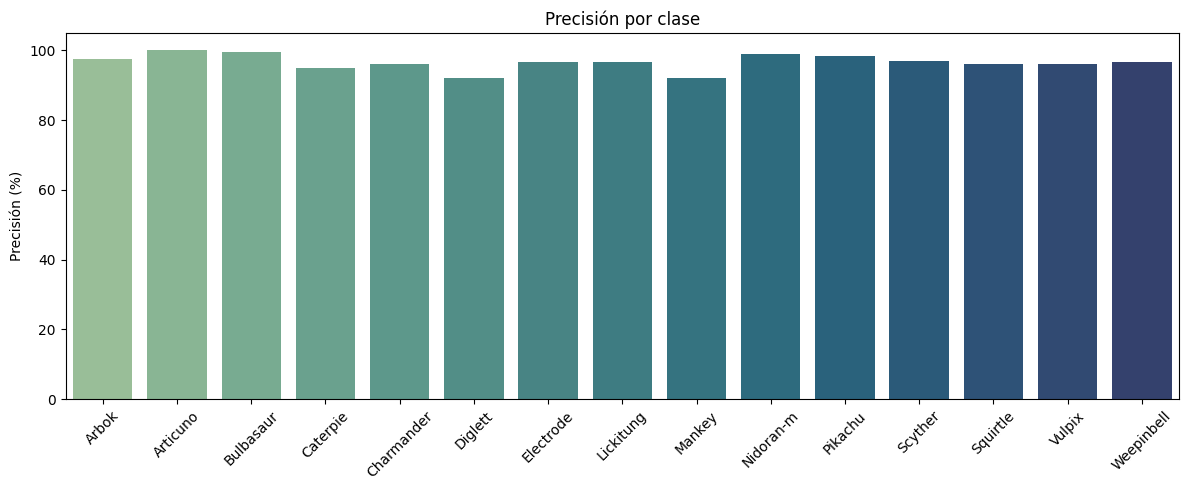

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tienes y_true (etiquetas reales) y y_pred (predichas)
# Calculamos precisión por clase manualmente:
from sklearn.metrics import accuracy_score

precisiones = []
for i, clase in enumerate(nombres_clases):
    indices = np.where(np.array(y_true) == i)[0]
    acc = accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])
    precisiones.append(acc * 100)

plt.figure(figsize=(12, 5))
sns.barplot(x=nombres_clases, y=precisiones, palette="crest")
plt.ylabel("Precisión (%)")
plt.title("Precisión por clase")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 11.5 Confianza Promedio por Clase (Radar Chart)

Este radar chart muestra, para cada clase, la confianza promedio que el modelo otorga a la predicción correcta. Una confianza baja en ciertas clases puede indicar debilidades del modelo en esas categorías.


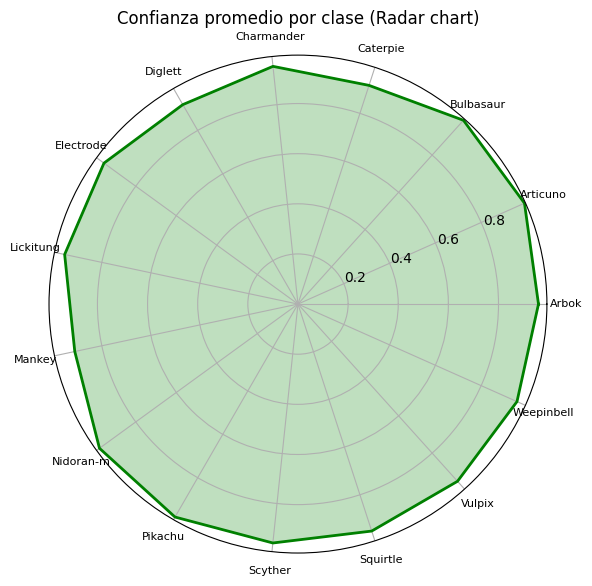

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Simulación de ejemplo: reemplaza con tus valores reales si ya los tienes
# confianza_promedio = [probabilidades medias para cada clase]

confianza = confianza_promedio.tolist()
confianza += confianza[:1]  # cerrar el círculo

angles = np.linspace(0, 2 * np.pi, len(nombres_clases), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, confianza, color='green', linewidth=2)
ax.fill(angles, confianza, color='green', alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(nombres_clases, size=8)
ax.set_title("Confianza promedio por clase (Radar chart)")
plt.tight_layout()
plt.show()


### 11.6 Visualización de Activaciones Internas

Esta sección permite observar cómo se activan internamente las neuronas en cada capa oculta del modelo durante la predicción de una imagen. Las activaciones reflejan cómo responde cada grupo de neuronas a características específicas de entrada.

El modelo ha sido diseñado para almacenar automáticamente las activaciones de cada capa oculta durante la inferencia. En los gráficos siguientes se representa la activación de cada neurona para una imagen seleccionada aleatoriamente del conjunto de prueba.

Esto permite interpretar si el modelo está utilizando de forma efectiva sus capas ocultas, detectar si existen capas muertas (neuronas que no activan) o si alguna capa está sobreactivada (saturada).


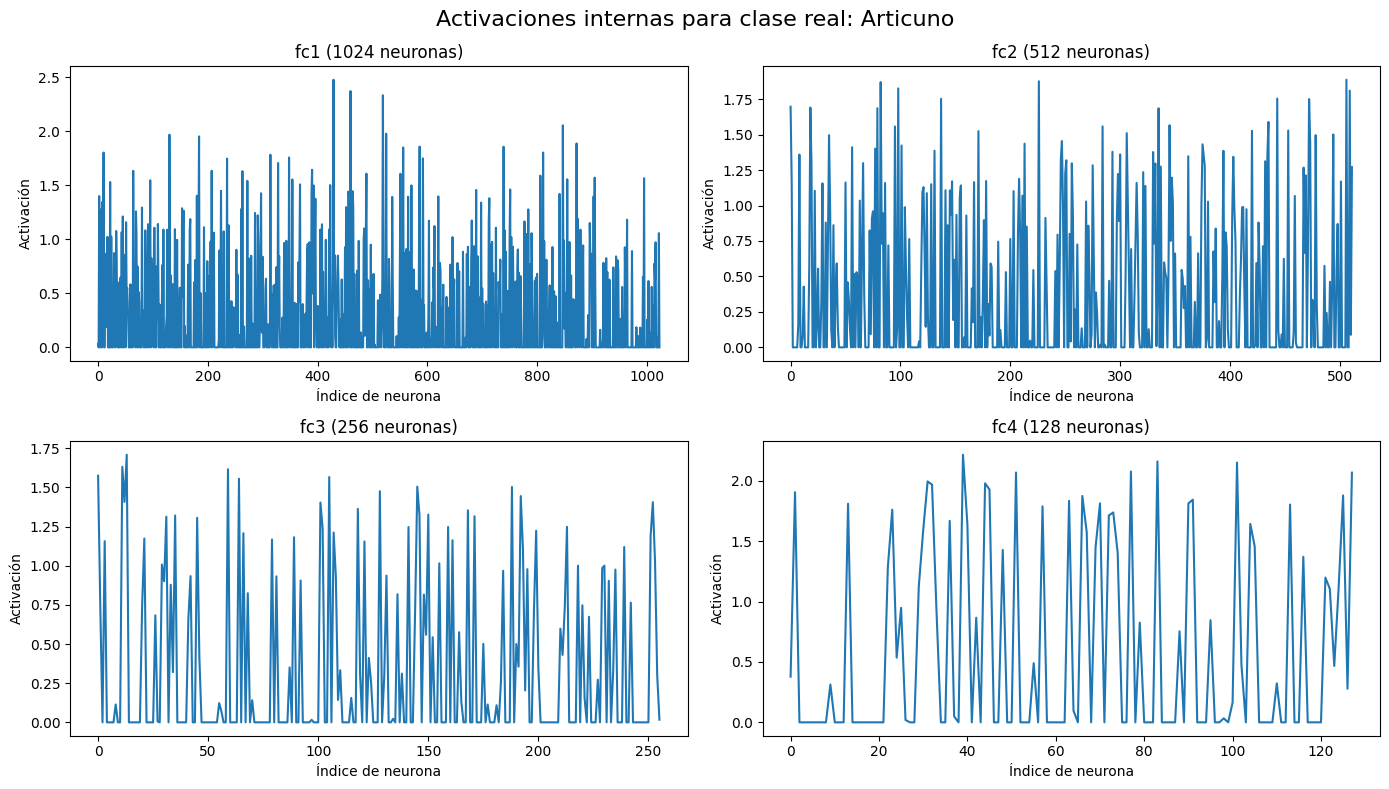

In [18]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Asegúrate de tener ya cargado `imagenes_tensor` y `etiquetas_tensor`
train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(
    imagenes_tensor, etiquetas_tensor,
    test_size=0.2,
    stratify=etiquetas_tensor,
    random_state=42
)


# Asegurar que el modelo esté en modo evaluación
model.eval()

# Seleccionar una imagen aleatoria del conjunto de prueba
indice = torch.randint(len(test_imgs), (1,)).item()
imagen = test_imgs[indice].unsqueeze(0).to(device)  # (1, 3, 40, 40)
etiqueta_real = test_lbls[indice].item()

# Pasar la imagen por el modelo para obtener activaciones
with torch.no_grad():
    _ = model(imagen)  # solo para registrar activaciones internas

# Obtener activaciones guardadas
activaciones = model.activaciones

# Crear gráfico
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle(f"Activaciones internas para clase real: {nombres_clases[etiqueta_real]}", fontsize=16)

# Dibujar cada capa
for ax, (nombre_capa, activacion) in zip(axes.flatten(), activaciones.items()):
    valores = activacion.squeeze().cpu()  # quitar batch y mover a CPU
    ax.plot(valores)
    ax.set_title(f"{nombre_capa} ({valores.numel()} neuronas)")
    ax.set_xlabel("Índice de neurona")
    ax.set_ylabel("Activación")

plt.tight_layout()
plt.show()
